# Enron email import script

I struggled to find a dataset that was exactly what we are looking for. It probably exists, but I built on a few other people's code and just rolled my own (brittle) parser. I think that it's doing a reasonable job.

I'll walk through what I do here.

**Note: You probably want to start running these scripts about halfway down, when we import the parquet file**

In [1]:
import numpy as np
import re
from datetime import datetime
import pandas as pd
import os

## Parsing functions

Here I create a few functions that parse the emails.

The basic logic is simple, but brittle. It assumes that the data is structured in the same way;
it basically looks, in order, for the ID, Datetime, Sender, and then recipients, based on how a line starts.
    
It looks for a line that starts with 'Mime-Version' to know that the metadata gathering is over, and then returns.

In [3]:
def retrieve_names(email):
    '''Takes in an email filename and returns a data dictionary with the following:
    {'sender': email in the 'From' field,
    'recipients': [List of recipients in To: and CC: fields],
    'id': Email id,
    'datetime': Timestamp of when email was sent
    }
    
    The basic logic is simple, but brittle. It assumes that the data is structured in the same way;
    it basically looks, in order, for the ID, Datetime, Sender, and then recipients, based on how a line starts.
    
    It looks for a line that starts with 'Mime-Version' to know that the metadata gathering is over, and then returns.
    '''
    extracted_data = {
        'sender': None,
        'recipients': [],
        'id': None,
        'datetime': None
    }
    with open(email, encoding='iso-8859-1') as f:
        gathering_recipients = False
        for line in f:
            line = line.strip()
            if line.startswith('Mime-Version'):
                if not extracted_data['sender']:
                    print(extracted_data, email)
                return extracted_data
            if not extracted_data['id']:
                id_match = re.match('Message-ID: \<(\d+\.\d+)', line)
                if id_match:
                    extracted_data['id'] = id_match.group(1)
            elif not extracted_data['datetime']:
                date_match = re.match('Date: \w{3}, (.*) -', line)
                if date_match:
                    extracted_data['datetime'] = datetime.strptime(date_match.group(1), f'%d %b %Y %H:%M:%S')
            elif not extracted_data['sender']:
                if line.startswith('From: '):
                    try:
                        extracted_data['sender'] = get_emails_from_line(line)[0]
                    except IndexError:
                        extracted_data['sender'] = 'MISSING'
                else:
                    # There are some odd email addresses - I'm just grabbing the whole thing - it 
                    print(line)
                    extracted_data['sender'] = re.match('From: (.*)', line).group(1)
            elif not extracted_data['recipients']:
                if line.startswith('To: '):
                    extracted_data['recipients'] = get_emails_from_line(line)
                    gathering_recipients = True
            elif line.startswith('Cc:'):
                extracted_data['recipients'] += get_emails_from_line(line)
                gathering_recipients = True
            elif gathering_recipients:
                # If there isn't an emal address in the line, then no more recipients; shut it down
                emails = get_emails_from_line(line)
                if not emails:
                    gathering_recipients = False
                    continue
                extracted_data['recipients'] += emails
            else:
                continue
            
                    
                
    if not extracted_data['sender']:
        print(extracted_data, email)
    print('Didn\'t find Mime-Version')    
    return extracted_data

def get_emails_from_line(line):
    '''Based on trial and error, I learned that for some reason there is a lot of junk around email addresses.
    Some of this may be user error, but I think that some is anonymization before data release. I try to make everything into as
    reasonable of an email address as possible, but a lot of invalid emails get kept, and there is going to be
    a lot of noise introduced here.
    
    Basically, this finds all strings of the type X@Y, where X and Y just don't include whitespace characters.
    It then strips out things like <,>, and quote marks.
    '''
    if line.startswith('Subject:'):
        return []
    emails = [re.sub(r"""[<>,"']""", '', x) for x in re.findall('\S+@\S+', line)]
    return emails


## Getting the data

We get the raw metadata by walking through every file in every directory

In [25]:
r = []
for dirname, _, filenames in os.walk('../data/maildir/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        #print(path)
        try:
            result = retrieve_names(os.path.join(dirname, filename))
        except UnicodeDecodeError:
            print(f"Unicode Error at {path}")
            raise
        result['fn'] = path
        r.append(result)

Next, we change it into an edgelist / dataframe.

I realized at this point that the email ID, which I thought was added to identify duplicate emails - does not do that. Because emails may appear in multiple places (e.g., in the sender's `sent` folder and the recipients' `inbox` folders), we need to deduplicate. In order to do that, I create an id as a combination of the datetime string and the sender's email. Initially, I thought this would be good enough to identify all duplicate emails, but I realized that while the resolution of the timestamps is down to the millisecond, in many cases the real resolution is the minute, and people can send more than one email in the same minute. So, this treats as duplicates any email sent at the same time to the same set of recipients.

This will have a few false positives (rapid-fire emails sent to the same people), but intuitively, maybe it makes sense to treat that as one email anyway.

In [45]:
edgelist = []
emails = {}
duplicates_skipped = []
possible_duplicates = []
for email in r:
    try:
        curr_id = datetime.strftime(email['datetime'], '%Y-%m-%d %H:%M:%S') + email['sender']
    except TypeError:
        print(email)
    if curr_id in emails:
        # If the same person sent an email to the same recipients at the same time, we assume it's a duplicate.
        # This will miss some emails sent within the same minute.
        if emails[curr_id]['recipients'] == email['recipients']:
            #print(f"Skipping duplicate email from {email['sender']} with id {email['id']}")
            duplicates_skipped.append((emails[curr_id]['fn'], email['fn']))
            continue
        else:
            possible_duplicates.append((emails[curr_id]['fn'], email['fn']))
            #print(f"Email {email['fn']} does not appear to be a duplicate. Previous email was {emails[curr_id]['fn']}")
    emails[curr_id] = email
    for recipient in email['recipients']:
        edgelist.append({'from': email['sender'],
                         'to': recipient,
                         'email_id': email['id'],
                         'date': email['datetime'],
                         'fn': email['fn']
                        })

Finally, we convert to a dataframe

In [46]:
df = pd.DataFrame(edgelist)

This takes some work to get into this format, and hopefully has everything we need, so let's save an intermediate file, so we don't have to parse all of the emails again.

When testing this, I learned that some of the timestamps from the email data are typos (weird), so we need to filter to just the emails with reasonable dates. 

Another option here is to simply strip dates, if we don't care about them. They are likely real emails, just with malformed dates.

In [127]:
df = df.loc[(df.date > pd.to_datetime('1990-01-01')) & (df.date < pd.to_datetime('2015-01-01'))]

In [128]:
df.to_parquet('../data/enron_full_edgelist.parquet')

In [65]:
df.to_csv('../data/enron_full_edgelist.csv')

# Start here when running the script!

From now on, we can start here and just load the dataframe.

In [2]:
# df = pd.read_parquet('../strength-friendship-paradox/data/email/enron_full_edgelist.parquet')
df = pd.read_parquet('../strength-friendship-paradox/data/email/enron_full_edgelist_v2.parquet')

## Filtering to the Enron employees

For this analysis, we are going to just use the emails from those whose email folders are included in this dataset.

One of the problems is that people might use multiple aliases, or their email may be partially redacted (I _think_ that's what the two dots in email addresses means?).

There are likely smarter ways to approach this, but my simple approach is to look in folders that include the word "sent" for each user, and count how often the sender of those emails is each email address. There are a surprising number of emails in `sent` not sent by the user, so we keep those where at least 25% of their emails came from that address.

One (minor?) weakness is that I'm only looking in `df`, where duplicates have been removed. For some users, this may mean that we don't have many items in their 'sent' folders; I haven't tested to see how big a problem this is.

In [3]:
# df['sent_items'] = df.fn.str.match('.*sent[^a]') # A few folder are called presentation, so this brittle regex finds 'sent' not followed by 'a'

This gets the 'username', which is the directory name in the dataset. We are going to use this to replace all of the email addresses used by the user.

In [4]:
# df['user'] = df.fn.str.extract("../data/maildir/([^-]+)", expand = False)

KT - I changed here because there are a few people who share the first names. 

In [5]:
df['user'] = df.fn.str.split(pat="/",expand=True)[3]

KT - I added an extra procedure of filtering out non enron domain email addresses

In [18]:
df = df.loc[(df['from'].str.contains('@enron.com')) & (df['to'].str.contains('@enron.com')),]

In [19]:
df['name_from'] = df['from'].str.split(pat="@",expand=True)[0]
df['name_to'] = df['to'].str.split(pat="@",expand=True)[0]

KT - set another filter to remove email address names that are shorter than 3

In [36]:
df = df.loc[(df['name_from'].str.len()>=3) & (df['name_to'].str.len()>=3),]

In [20]:
len(pd.unique(df.user))

150

In [21]:
np.sort(pd.unique(df.user))

array(['allen-p', 'arnold-j', 'arora-h', 'badeer-r', 'bailey-s', 'bass-e',
       'baughman-d', 'beck-s', 'benson-r', 'blair-l', 'brawner-s',
       'buy-r', 'campbell-l', 'carson-m', 'cash-m', 'causholli-m',
       'corman-s', 'crandell-s', 'cuilla-m', 'dasovich-j', 'davis-d',
       'dean-c', 'delainey-d', 'derrick-j', 'dickson-s', 'donoho-l',
       'donohoe-t', 'dorland-c', 'ermis-f', 'farmer-d', 'fischer-m',
       'forney-j', 'fossum-d', 'gang-l', 'gay-r', 'geaccone-t',
       'germany-c', 'gilbertsmith-d', 'giron-d', 'griffith-j',
       'grigsby-m', 'guzman-m', 'haedicke-m', 'hain-m', 'harris-s',
       'hayslett-r', 'heard-m', 'hendrickson-s', 'hernandez-j', 'hodge-j',
       'holst-k', 'horton-s', 'hyatt-k', 'hyvl-d', 'jones-t',
       'kaminski-v', 'kean-s', 'keavey-p', 'keiser-k', 'king-j',
       'kitchen-l', 'kuykendall-t', 'lavorato-j', 'lay-k', 'lenhart-m',
       'lewis-a', 'linder-e', 'lokay-m', 'lokey-t', 'love-p', 'lucci-p',
       'maggi-m', 'mann-k', 'martin-t', '

In [22]:
df.loc[df.user=='allen-p',]

,from,to,email_id,date,fn,user,name_from,name_to
464290,phillip.allen@enron.com,james.steffes@enron.com,7772986.1075855718303,2001-01-12 05:18:00,../data/maildir/allen-p/sent/522.,allen-p,phillip.allen,james.steffes
464294,phillip.allen@enron.com,keith.holst@enron.com,29418410.1075855716379,2001-02-21 07:57:00,../data/maildir/allen-p/sent/439.,allen-p,phillip.allen,keith.holst
464296,phillip.allen@enron.com,kathy.moore@enron.com,20726955.1075855681529,2000-09-22 00:06:00,../data/maildir/allen-p/sent/81.,allen-p,phillip.allen,kathy.moore
464298,phillip.allen@enron.com,frank.ermis@enron.com,30542117.1075855683251,2000-07-26 03:44:00,../data/maildir/allen-p/sent/160.,allen-p,phillip.allen,frank.ermis
464300,phillip.allen@enron.com,andrea.richards@enron.com,31383462.1075855718238,2001-01-12 05:46:00,../data/maildir/allen-p/sent/519.,allen-p,phillip.allen,andrea.richards
...,...,...,...,...,...,...,...,...
465851,david.oxley@enron.com,k..allen@enron.com,31510491.1075862163166,2001-11-26 09:44:02,../data/maildir/allen-p/deleted_items/420.,allen-p,david.oxley,k..allen
465852,david.oxley@enron.com,pam.butler@enron.com,31510491.1075862163166,2001-11-26 09:44:02,../data/maildir/allen-p/deleted_items/420.,allen-p,david.oxley,pam.butler
465855,frank.hayden@enron.com,k..allen@enron.com,27968917.1075855376522,2001-12-17 14:53:58,../data/maildir/allen-p/deleted_items/66.,allen-p,frank.hayden,k..allen
465856,frank.hayden@enron.com,c..gossett@enron.com,27968917.1075855376522,2001-12-17 14:53:58,../data/maildir/allen-p/deleted_items/66.,allen-p,frank.hayden,c..gossett


In [10]:
# temp = df[df.sent_items == True].groupby(['user', 'from']).size()

Figure out the proportion of emails sent from each email address, for each user.

In [11]:
# temp = temp.agg({'prop':lambda x: x / x.sum(level=0)}).unstack(level=0).reset_index()

In [12]:
# temp

In [13]:
# temp_from = df.groupby(['user', 'from']).size()
# temp_to = df.groupby(['user', 'to']).size()

In [14]:
# temp_agg_from = temp_from.agg({'prop':lambda x: x / x.sum(level=0)}).unstack(level=0).reset_index()
# temp_agg_to = temp_to.agg({'prop':lambda x: x / x.sum(level=0)}).unstack(level=0).reset_index()
# temp_agg_from

KT - I use a fuzzy matching approach to identifying the connection between user names and email addresses.

In [15]:
from fuzzywuzzy import fuzz

In [38]:
temp_from = df.groupby(['user', 'name_from']).size().reset_index()
# temp_from['ratio'] = temp_from.apply(lambda x: fuzz.partial_ratio(x['user'], x['name_from']))
temp_from['prop'] = temp_from.apply(lambda x: fuzz.partial_ratio(x['user'], x['name_from']), axis=1)
temp_from

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\au688666\Anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\au688666\Anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,user,name_from,0,prop
0,allen-p,adrianne.engler,3,29
1,allen-p,alyse.herasimchuk,14,43
2,allen-p,c..aucoin,2,29
3,allen-p,c..gossett,2,14
4,allen-p,chad.landry,1,43
...,...,...,...,...
18213,zufferli-j,ryan.watt,1,11
18214,zufferli-j,sharon.crawford,8,20
18215,zufferli-j,stephane.brodeur,2,20
18216,zufferli-j,stephanie.sever,5,20


In [24]:
temp_from.loc[(temp_from.user=='allen-p') & (temp_from.prop > 70),]

,user,name_from,0,prop
14,allen-p,k..allen,182,83
25,allen-p,phillip.allen,478,83


In [39]:
temp_to = df.groupby(['user', 'name_to']).size().reset_index()
# temp_from['ratio'] = temp_from.apply(lambda x: fuzz.partial_ratio(x['user'], x['name_from']))
temp_to['prop'] = temp_to.apply(lambda x: fuzz.partial_ratio(x['user'], x['name_to']), axis=1)
temp_to

,user,name_to,0,prop
0,allen-p,40enron,2,29
1,allen-p,a..martin,2,29
2,allen-p,aamir.maniar,1,29
3,allen-p,adrianne.engler,5,29
4,allen-p,al.pollard,5,43
...,...,...,...,...
128289,zufferli-j,w..white,5,12
128290,zufferli-j,wayne.vinson,1,20
128291,zufferli-j,wendy.conwell,2,20
128292,zufferli-j,wes.colwell,2,20


In [26]:
temp_to.loc[(temp_to.user=='allen-p') & (temp_to.prop > 70),]

,user,name_to,0,prop
125,allen-p,k..allen,32,83
174,allen-p,pallen,1,83
180,allen-p,phillip.allen,13,83
181,allen-p,phillip.k.allen,6,83


In [66]:
# Restrict to those where proportion is greater than 25% of emails sent
# email_mapping_df = temp.loc[temp.prop > .25, ['user', 'from']]

In [40]:
# filter out below 80 fuzzy match score
email_mapping_rev_df = temp_from.loc[(temp_from.prop > 79),]
email_mapping_rev_df = email_mapping_rev_df.append(temp_to.loc[(temp_to.prop > 79),].rename(columns={'name_to':'name_from'}))
# drop duplicates
email_mapping_rev_df = email_mapping_rev_df.drop_duplicates(
  subset = ['user', 'name_from']).reset_index(drop = True)
# sort by usernames
email_mapping_rev_df.sort_values(by=['user'])

,user,name_from,0,prop
0,allen-p,k..allen,182,83
207,allen-p,phillip.k.allen,6,83
206,allen-p,pallen,1,83
1,allen-p,phillip.allen,476,83
3,arnold-j,matthew.arnold,4,86
...,...,...,...,...
407,ybarbo-p,barbo,14,100
203,ybarbo-p,paul.ybarbo,316,86
204,zipper-a,andy.zipper,399,86
409,zipper-a,zipper.andy,1,88


In [42]:
# pd.set_option('display.max_rows', None)
pd.reset_option("all")
email_mapping_rev_df.sort_values(by=['user'])

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\au688666\Anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\au688666\Anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,user,name_from,0,prop
0,allen-p,k..allen,182,83
207,allen-p,phillip.k.allen,6,83
206,allen-p,pallen,1,83
1,allen-p,phillip.allen,476,83
3,arnold-j,matthew.arnold,4,86
...,...,...,...,...
407,ybarbo-p,barbo,14,100
203,ybarbo-p,paul.ybarbo,316,86
204,zipper-a,andy.zipper,399,86
409,zipper-a,zipper.andy,1,88


In [55]:
email_mapping_rev_df['name_from']
# email_mapping_rev_df['name_from'].tolist()

0            k..allen
1       phillip.allen
2         john.arnold
3      matthew.arnold
4       robert.badeer
            ...      
405        jeff.wolfe
406        tony.wolfe
407             barbo
408           pybarbo
409       zipper.andy
Name: name_from, Length: 410, dtype: object

In [62]:
df['user_from'] = df['name_from'].map(dict(zip(email_mapping_rev_df['name_from'],email_mapping_rev_df['user'])))
df['user_to'] = df['name_to'].map(dict(zip(email_mapping_rev_df['name_from'],email_mapping_rev_df['user'])))
df

C:\Users\au688666\AppData\Local\Temp/ipykernel_25232/2212358387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_from'] = df['name_from'].map(dict(zip(email_mapping_rev_df['name_from'],email_mapping_rev_df['user'])))
C:\Users\au688666\AppData\Local\Temp/ipykernel_25232/2212358387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_to'] = df['name_to'].map(dict(zip(email_mapping_rev_df['name_from'],email_mapping_rev_df['user'])))


,from,to,email_id,date,fn,user,name_from,name_to,user_from,user_to
0,matthew.duffy@enron.com,m..forney@enron.com,6551667.1075861680836,2001-11-12 11:51:16,../data/maildir/forney-j/inbox/134.,forney-j,matthew.duffy,m..forney,NaN,forney-j
15,ramanarao.tamma@enron.com,chris.lenartowicz@enron.com,24866768.1075852397438,2001-10-18 15:22:15,../data/maildir/forney-j/inbox/7.,forney-j,ramanarao.tamma,chris.lenartowicz,NaN,NaN
16,ramanarao.tamma@enron.com,l..day@enron.com,24866768.1075852397438,2001-10-18 15:22:15,../data/maildir/forney-j/inbox/7.,forney-j,ramanarao.tamma,l..day,NaN,NaN
17,ramanarao.tamma@enron.com,william.freije@enron.com,24866768.1075852397438,2001-10-18 15:22:15,../data/maildir/forney-j/inbox/7.,forney-j,ramanarao.tamma,william.freije,NaN,NaN
18,ramanarao.tamma@enron.com,m..forney@enron.com,24866768.1075852397438,2001-10-18 15:22:15,../data/maildir/forney-j/inbox/7.,forney-j,ramanarao.tamma,m..forney,NaN,forney-j
...,...,...,...,...,...,...,...,...,...,...
1383974,carol.clair@enron.com,andrew.wilson@enron.com,30585682.1075842191648,1979-12-31 16:00:00,../data/maildir/stclair-c/all_documents/2302.,stclair-c,carol.clair,andrew.wilson,NaN,NaN
1383975,james.keller@enron.com,jeffrey.hodge@enron.com,33395769.1075842193311,2001-05-20 03:01:00,../data/maildir/stclair-c/all_documents/2367.,stclair-c,james.keller,jeffrey.hodge,NaN,hodge-j
1383976,james.keller@enron.com,carol.clair@enron.com,33395769.1075842193311,2001-05-20 03:01:00,../data/maildir/stclair-c/all_documents/2367.,stclair-c,james.keller,carol.clair,NaN,NaN
1383977,james.keller@enron.com,elizabeth.sager@enron.com,33395769.1075842193311,2001-05-20 03:01:00,../data/maildir/stclair-c/all_documents/2367.,stclair-c,james.keller,elizabeth.sager,NaN,NaN


In [63]:
df.dropna()

,from,to,email_id,date,fn,user,name_from,name_to,user_from,user_to
50,clint.dean@enron.com,doug.gilbert-smith@enron.com,26115013.1075852398292,2001-10-23 11:50:01,../data/maildir/forney-j/inbox/30.,forney-j,clint.dean,doug.gilbert-smith,dean-c,gilbertsmith-d
51,clint.dean@enron.com,m..forney@enron.com,26115013.1075852398292,2001-10-23 11:50:01,../data/maildir/forney-j/inbox/30.,forney-j,clint.dean,m..forney,dean-c,forney-j
59,doug.gilbert-smith@enron.com,m..forney@enron.com,6746595.1075861680999,2001-11-12 15:54:55,../data/maildir/forney-j/inbox/141.,forney-j,doug.gilbert-smith,m..forney,gilbertsmith-d,forney-j
60,doug.gilbert-smith@enron.com,w..white@enron.com,6746595.1075861680999,2001-11-12 15:54:55,../data/maildir/forney-j/inbox/141.,forney-j,doug.gilbert-smith,w..white,gilbertsmith-d,white-s
66,doug.gilbert-smith@enron.com,m..forney@enron.com,6968390.1075859220528,2001-11-27 08:11:47,../data/maildir/forney-j/inbox/52.,forney-j,doug.gilbert-smith,m..forney,gilbertsmith-d,forney-j
...,...,...,...,...,...,...,...,...,...,...
1376615,steven.harris@enron.com,kevin.hyatt@enron.com,16534395.1075860865683,2002-02-14 13:53:05,../data/maildir/hyatt-k/deleted_items/332.,hyatt-k,steven.harris,kevin.hyatt,harris-s,hyatt-k
1377204,kimberly.watson@enron.com,kevin.hyatt@enron.com,7234658.1075860866032,2002-02-19 11:12:58,../data/maildir/hyatt-k/deleted_items/345.,hyatt-k,kimberly.watson,kevin.hyatt,watson-k,hyatt-k
1377266,steven.harris@enron.com,kevin.hyatt@enron.com,24303839.1075860865660,2002-02-15 14:20:54,../data/maildir/hyatt-k/deleted_items/331.,hyatt-k,steven.harris,kevin.hyatt,harris-s,hyatt-k
1377503,monika.causholli@enron.com,monika.causholli@enron.com,23571897.1075853164917,2001-10-19 18:18:51,../data/maildir/causholli-m/inbox/30.,causholli-m,monika.causholli,monika.causholli,causholli-m,causholli-m


In [65]:
df_rev = df.dropna().groupby('email_id').filter(lambda x: len(x) < 4)
df_rev

,from,to,email_id,date,fn,user,name_from,name_to,user_from,user_to
50,clint.dean@enron.com,doug.gilbert-smith@enron.com,26115013.1075852398292,2001-10-23 11:50:01,../data/maildir/forney-j/inbox/30.,forney-j,clint.dean,doug.gilbert-smith,dean-c,gilbertsmith-d
51,clint.dean@enron.com,m..forney@enron.com,26115013.1075852398292,2001-10-23 11:50:01,../data/maildir/forney-j/inbox/30.,forney-j,clint.dean,m..forney,dean-c,forney-j
59,doug.gilbert-smith@enron.com,m..forney@enron.com,6746595.1075861680999,2001-11-12 15:54:55,../data/maildir/forney-j/inbox/141.,forney-j,doug.gilbert-smith,m..forney,gilbertsmith-d,forney-j
60,doug.gilbert-smith@enron.com,w..white@enron.com,6746595.1075861680999,2001-11-12 15:54:55,../data/maildir/forney-j/inbox/141.,forney-j,doug.gilbert-smith,w..white,gilbertsmith-d,white-s
66,doug.gilbert-smith@enron.com,m..forney@enron.com,6968390.1075859220528,2001-11-27 08:11:47,../data/maildir/forney-j/inbox/52.,forney-j,doug.gilbert-smith,m..forney,gilbertsmith-d,forney-j
...,...,...,...,...,...,...,...,...,...,...
1376615,steven.harris@enron.com,kevin.hyatt@enron.com,16534395.1075860865683,2002-02-14 13:53:05,../data/maildir/hyatt-k/deleted_items/332.,hyatt-k,steven.harris,kevin.hyatt,harris-s,hyatt-k
1377204,kimberly.watson@enron.com,kevin.hyatt@enron.com,7234658.1075860866032,2002-02-19 11:12:58,../data/maildir/hyatt-k/deleted_items/345.,hyatt-k,kimberly.watson,kevin.hyatt,watson-k,hyatt-k
1377266,steven.harris@enron.com,kevin.hyatt@enron.com,24303839.1075860865660,2002-02-15 14:20:54,../data/maildir/hyatt-k/deleted_items/331.,hyatt-k,steven.harris,kevin.hyatt,harris-s,hyatt-k
1377503,monika.causholli@enron.com,monika.causholli@enron.com,23571897.1075853164917,2001-10-19 18:18:51,../data/maildir/causholli-m/inbox/30.,causholli-m,monika.causholli,monika.causholli,causholli-m,causholli-m


In [68]:
el = df_rev.groupby(['user_from', 'user_to']).aggregate(weight = ('user_to', 'size')).reset_index().rename(columns={'user_from':'from','user_to':'to'})
el

,from,to,weight
0,allen-p,badeer-r,5
1,allen-p,beck-s,1
2,allen-p,benson-r,4
3,allen-p,dasovich-j,2
4,allen-p,delainey-d,2
...,...,...,...
2157,zufferli-j,richey-c,17
2158,zufferli-j,shankman-j,1
2159,zufferli-j,shively-h,1
2160,zufferli-j,taylor-m,1


KT - My guess is `panus` and `phanis` are two different people. 

Convert to a dictionary that can be passed to the `pd.map` function.

Note that this has "debugging" to make sure that an email isn't mapped to more than one user.

There is one that gets flagged - `stephanie.panus@enron.com` gets mapped to both `panus` and `phanis`. I believe that this is the same user, and somehow her mailbox got split between two directories.

In [264]:
email_mapping_dict = {}
for _, data in email_mapping.iterrows():
    if data['from'] in email_mapping_dict:
        print(data['from'], email_mapping_dict[data['from']])
    email_mapping_dict[data['from']] = data['user']

stephanie.panus@enron.com panus


Run the following to inspect the dictionary; it appears reasonable.

In [ ]:
email_mapping_dict

Ok - now we have a mapping from email addresses to users that we feel moderately confident about. Let's remove giant emails (sent to more than 4 others) and everyone from the network who isn't in this list, and then replace their emails with their usernames

In [188]:
df = df.groupby('email_id').filter(lambda x: len(x) < 5)

In [189]:
df = df[df['from'].isin(email_mapping_dict) &  df['to'].isin(email_mapping_dict)]

In [190]:
df['from'] = df['from'].map(email_mapping_dict)

In [191]:
df['to'] = df['to'].map(email_mapping_dict)

We're almost ready. We're now going to change this from a row for each email to a row for each `(from,to)` pair, and save the number of rows as `weight`.

In [204]:
el = df.groupby(['from', 'to']).aggregate(weight = ('to', 'size')).reset_index()

In [211]:
el

,from,to,weight
0,allen,badeer,5
1,allen,beck,1
2,allen,dasovich,2
3,allen,delainey,2
4,allen,ermis,14
...,...,...,...
1753,zufferli,kitchen,1
1754,zufferli,lavorato,10
1755,zufferli,mckay,2
1756,zufferli,richey,15


Finally, we're going to turn the weights symmetrical. We save two different weights - the minimum weight (`weight`) and the mean weight (`mean_weight`)

In [69]:
new_el = []
completed = []
for _, row in el.iterrows():
    if (row['to'],row['from']) in completed:
        continue
    tmp = el[(el['from'] == row['to']) & (el['to'] == row['from'])]
    try:
        min_weight = min(min(tmp['weight']), row['weight'])
    except ValueError:
        # Don't keep edges that aren't reciprocal
        continue
    try:
        mean_weight = np.mean((min(tmp['weight']), row['weight']))
    except ValueError:
        print('I don\'t think this should happen')
        mean_weight = 0
    new_el.append({
        'from': row['from'], 
        'to': row['to'], 
        'weight': min_weight,
        'mean_weight': mean_weight
    })
    completed.append((row['from'],row['to']))
new_el = pd.DataFrame(new_el)

In [71]:
new_el

,from,to,weight,mean_weight
0,allen-p,dasovich-j,2,3.5
1,allen-p,delainey-d,2,2.5
2,allen-p,grigsby-m,22,32.0
3,allen-p,hodge-j,1,1.0
4,allen-p,holst-k,5,25.0
...,...,...,...,...
813,williams-j,williams-j,41,41.0
814,williams-j,williams-w3,1,2.0
815,williams-w3,williams-w3,79,79.0
816,ybarbo-p,ybarbo-p,4,4.0


In [81]:
df = new_el.rename(columns={'from': 'node1','to':'node2','mean_weight':'w'})

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

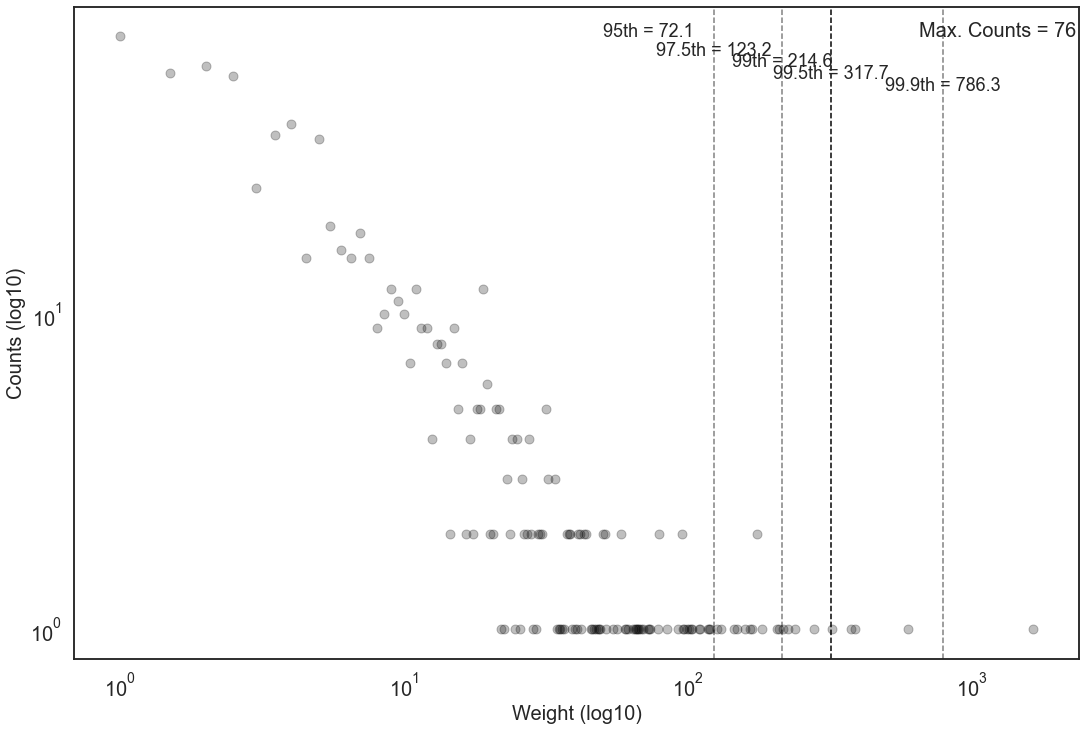

In [80]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# creae the weight distribution
dist_df = pd.DataFrame(list(Counter(df.w).items()))
# dist_df = dist_df.applymap(log10)
dist_df.columns = ["weight", "counts"]

# plot
sns.set(style="white", context="talk",rc={'figure.figsize':(18,12)})
# sns.lmplot(x="weight", y="counts", data=dist_df, scatter=True)
               #markers='.', scatter_kws={"s": 10})
sns.regplot(x="weight", y="counts", data=dist_df,fit_reg=False, 
            color = '#000000', scatter_kws={'alpha':0.25})
plt.text(650,dist_df['counts'].max(), 'Max. Counts = {:g}'.format(dist_df['counts'].max()),fontsize=20)
plt.text(df['w'].quantile(.95),dist_df['counts'].max(), '95th = {:.1f}'.format(df['w'].quantile(.95)),fontsize=18,ha='center')
plt.axvline(x=df['w'].quantile(.975),
            alpha =.5,
            color= '#000000',
            ls='--', 
            lw=1.5)
plt.text(df['w'].quantile(.975),dist_df['counts'].max()-10, '97.5th = {:.1f}'.format(df['w'].quantile(.975)),fontsize=18,ha='center')
plt.axvline(x=df['w'].quantile(.99),
            alpha =.5,
            color= '#000000',
            ls='--', 
            lw=1.5)
plt.text(df['w'].quantile(.99),dist_df['counts'].max()-15, '99th = {:.1f}'.format(df['w'].quantile(.99)),fontsize=18,ha='center')
plt.axvline(x=df['w'].quantile(.995),
            color= '#000000',
            ls='--', 
            lw=1.5)
plt.text(df['w'].quantile(.995),dist_df['counts'].max()-20, '99.5th = {:.1f}'.format(df['w'].quantile(.995)),fontsize=18,ha='center')
plt.axvline(x=df['w'].quantile(.999),
            alpha =.5,
            color= '#000000',
            ls='--', 
            lw=1.5)
plt.text(df['w'].quantile(.999),dist_df['counts'].max()-25, '99.9th = {:.1f}'.format(df['w'].quantile(.999)),fontsize=18,ha='center')
# g.figure.set_size_inches(12,12)
# g.set(xscale="log", yscale="log")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Weight (log10)', fontsize = 20)
plt.ylabel('Counts (log10)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

In [82]:
def FP(df):
    '''calculate the strength of FP index'''
    fp = 1 + df['std']/df['mean']**2
    return(fp)

def summary_stat(percent = .5):
    '''
    calculate summary degree stat
    input: percent e.g., .5, .6, 1
    '''
    cutoff = df['w'].quantile(percent)
    # calculate Mean and SD
    def sum_stat(degree_df):
        sum_df = degree_df.agg({'degree':['mean','std','min','max']})
        sum_df = sum_df.T.reset_index(drop=True)
        return(sum_df)
    # separate cases
    if percent == 1:
        # degree calculation
        A_degree = pd.DataFrame(list(Counter(df.loc[:,'node1'].append(df.loc[:,'node2'])).items()))
        A_degree.columns = ["node", "degree"]
        sum_df = sum_stat(A_degree)
        sum_df['type'] = 'All'
        sum_S['n'] = len(A_degree.index)
        sum_df['n%'] = len(A_degree.index)/len(pd.unique(df.iloc[:,0:2].values.ravel('K')))*100
    else:
        # separate Strong vs. Weak
        S_df = df.loc[df.w >= cutoff,:]
        W_df = df.loc[df.w < cutoff,:]
        # degree calculaion
        S_degree = pd.DataFrame(list(Counter(S_df.loc[:,'node1'].append(S_df.loc[:,'node2'])).items()))
        S_degree.columns = ["node", "degree"]
        W_degree = pd.DataFrame(list(Counter(W_df.loc[:,'node1'].append(W_df.loc[:,'node2'])).items()))
        W_degree.columns = ["node", "degree"]
        sum_S = sum_stat(S_degree)
        sum_S['type'] = 'Strong'
        sum_W = sum_stat(W_degree)
        sum_W['type'] = 'Weak'
        sum_S['n'] = len(S_degree.index)
        sum_W['n'] = len(W_degree.index)
        sum_S['n%'] = len(S_degree.index)/len(pd.unique(df.iloc[:,0:2].values.ravel('K')))*100
        sum_W['n%'] = len(W_degree.index)/len(pd.unique(df.iloc[:,0:2].values.ravel('K')))*100
        sum_df = sum_S.append(sum_W)
    # add extra info
    sum_df['percentile'] = percent
    sum_df['cutoff'] = cutoff
    sum_df['country'] = d_name.split(sep='_')[0]
    return(sum_df)

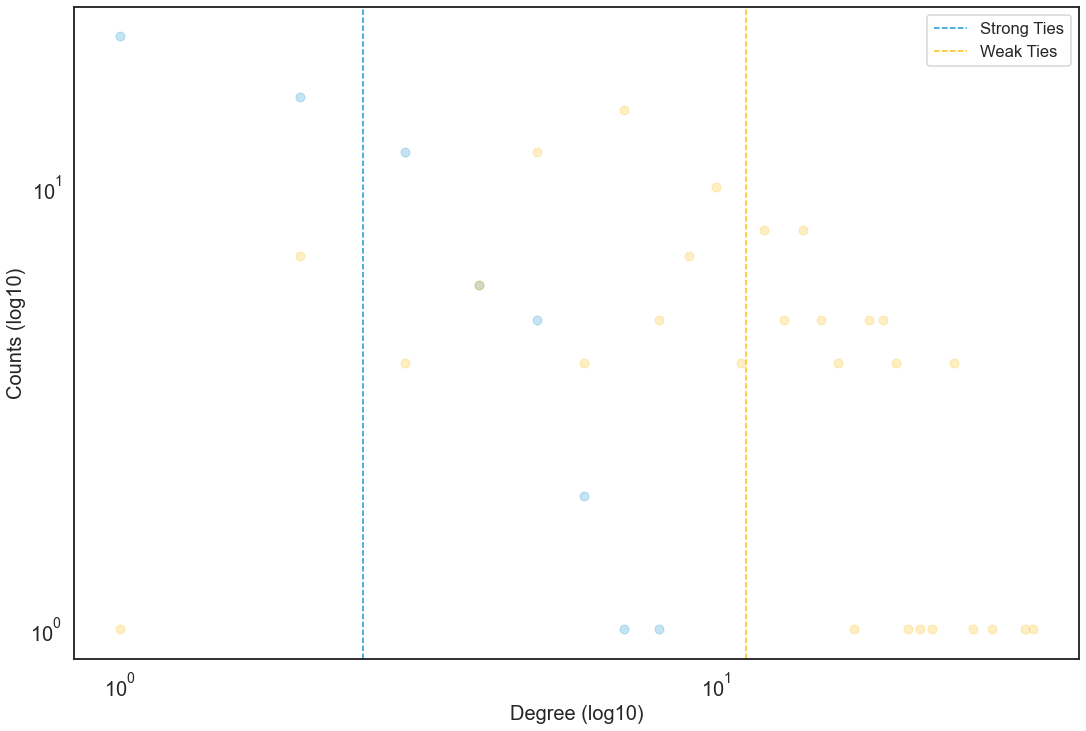

In [84]:
# set up a cutoff by quantile
cutoff = df['w'].quantile(.9)
# separate Strong vs. Weak
S_df = df.loc[df.w >= cutoff,:]
W_df = df.loc[df.w < cutoff,:]

# degree calculaion
S_degree = pd.DataFrame(list(Counter(S_df.loc[:,'node1'].append(S_df.loc[:,'node2'])).items()))
S_degree.columns = ["node", "degree"]
S_df = pd.DataFrame(list(Counter(S_degree.degree).items()))
S_df.columns = ["degree", "counts"]
W_degree = pd.DataFrame(list(Counter(W_df.loc[:,'node1'].append(W_df.loc[:,'node2'])).items()))
W_degree.columns = ["node", "degree"]
W_df = pd.DataFrame(list(Counter(W_degree.degree).items()))
W_df.columns = ["degree", "counts"]

# plot
sns.set(style="white", context="talk",rc={'figure.figsize':(18,12)})
sns.regplot(x="degree", y="counts", data=S_df,fit_reg=False, 
            color = '#1696d2', scatter_kws={'alpha':0.25})
plt.axvline(x=S_degree['degree'].mean(),
            color= '#1696d2',
            ls='--', 
            lw=1.5)
sns.regplot(x="degree", y="counts", data=W_df,fit_reg=False, 
            color = '#fdbf11', scatter_kws={'alpha':0.25})
plt.axvline(x=W_degree['degree'].mean(),
            color= '#fdbf11',
            ls='--', 
            lw=1.5)
# g.figure.set_size_inches(12,12)
# g.set(xscale="log", yscale="log")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log10)', fontsize = 20) # x-axis label with fontsize 15
plt.ylabel('Counts (log10)', fontsize = 20) # y-axis label with fontsize 15
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper right', labels=['Strong Ties', 'Weak Ties'])

In [86]:
# stat_df = pd.concat([summary_stat(percent = x) for x in [.5,.6,.7,.8,.9,1]])
d_name = 'Enron'
stat_df = pd.concat([summary_stat(percent = x) for x in [.999,.995,.975,.99,.95,.90]])
stat_df['FP'] = FP(stat_df)
stat_df

,mean,std,min,max,type,n,n%,percentile,cutoff,country,FP
0,2.000000,NaN,2.0,2.0,Strong,1,0.757576,0.999,786.2775,Enron,NaN
0,12.378788,7.783845,1.0,40.0,Weak,132,100.000000,0.999,786.2775,Enron,1.050797
0,1.666667,1.211060,1.0,4.0,Strong,6,4.545455,0.995,317.7175,Enron,1.435982
0,12.318182,7.719627,1.0,39.0,Weak,132,100.000000,0.995,317.7175,Enron,1.050875
0,2.100000,1.252366,1.0,5.0,Strong,20,15.151515,0.975,123.2375,Enron,1.283983
0,12.075758,7.638414,1.0,38.0,Weak,132,100.000000,0.975,123.2375,Enron,1.052381
0,2.000000,1.000000,1.0,4.0,Strong,9,6.818182,0.990,214.6400,Enron,1.250000
0,12.257576,7.679278,1.0,39.0,Weak,132,100.000000,0.990,214.6400,Enron,1.051111
0,2.000000,1.322876,1.0,6.0,Strong,41,31.060606,0.950,72.0750,Enron,1.330719
0,11.862595,7.239596,1.0,35.0,Weak,131,99.242424,0.950,72.0750,Enron,1.051446


And, we save this as the final edgelist.

In [267]:
new_el.to_parquet('../data/enron_filtered_edgelist.parquet')
new_el.to_csv('../data/enron_filtered_edgelist.csv')